In [1]:
from __future__ import division
%matplotlib inline

import numpy as np
from scipy import optimize, signal
import pandas as pd
from pandas_datareader.data import DataReader
import statsmodels.api as sm
from statsmodels.tools.numdiff import approx_fprime, approx_fprime_cs
from IPython.display import display
import matplotlib.pyplot as plt
# import seaborn as sn

from numpy.testing import assert_allclose

# Set some pretty-printing options
np.set_printoptions(precision=3, suppress=True, linewidth=120)
pd.set_option('float_format', lambda x: '%.3g' % x, )


In [2]:
equation_names = [
    'static FOC', 'euler equation', 'production',
    'aggregate resource constraint', 'capital accumulation',
    'labor-leisure', 'technology shock transition'
]
variable_names = [
    'output', 'consumption', 'investment',
    'labor', 'leisure', 'capital', 'technology'
]
parameter_names = [
    'discount rate', 'marginal disutility of labor',
    'depreciation rate', 'capital share',
    'technology shock persistence',
    'technology shock standard deviation',
]

# Save some symbolic forms for pretty-printing
variable_symbols = [
    r"y", r"c", r"i", r"n", r"l", r"k", r"z",
]
contemporaneous_variable_symbols = [
    r"$%s_t$" % symbol for symbol in variable_symbols
]
lead_variable_symbols = [
    r"$%s_{t+1}$" % symbol for symbol in variable_symbols
]

parameter_symbols = [
    r"$\beta$", r"$\psi$", r"$\delta$", r"$\alpha$", r"$\rho$", r"$\sigma^2$"
]


In [3]:
class RBC1(object):
    def __init__(self, params=None):
        # Model dimensions
        self.k_params = 6
        self.k_variables = 7

        # Initialize parameters
        if params is not None:
            self.update(params)

    def update(self, params):
        # Save deep parameters
        self.discount_rate = params[0]
        self.disutility_labor = params[1]
        self.depreciation_rate = params[2]
        self.capital_share = params[3]
        self.technology_shock_persistence = params[4]
        self.technology_shock_std = params[5]

    def eval_logged(self, log_lead, log_contemporaneous):
        (log_lead_output, log_lead_consumption, log_lead_investment,
         log_lead_labor, log_lead_leisure, log_lead_capital,
         log_lead_technology_shock) = log_lead

        (log_output, log_consumption, log_investment, log_labor,
         log_leisure, log_capital, log_technology_shock) = log_contemporaneous

        return np.r_[
            self.log_static_foc(
                log_lead_consumption, log_lead_labor,
                log_lead_capital, log_lead_technology_shock
            ),
            self.log_euler_equation(
                log_lead_consumption, log_lead_labor,
                log_lead_capital, log_lead_technology_shock,
                log_consumption
            ),
            self.log_production(
                log_lead_output, log_lead_labor, log_lead_capital,
                log_lead_technology_shock
            ),
            self.log_aggregate_resource_constraint(
                log_lead_output, log_lead_consumption,
                log_lead_investment
            ),
            self.log_capital_accumulation(
                log_lead_capital, log_investment, log_capital
            ),
            self.log_labor_leisure_constraint(
                log_lead_labor, log_lead_leisure
            ),
            self.log_technology_shock_transition(
                log_lead_technology_shock, log_technology_shock
            )
        ]

    def log_static_foc(self, log_lead_consumption, log_lead_labor,
                       log_lead_capital, log_lead_technology_shock):
        return (
            np.log(self.disutility_labor) +
            log_lead_consumption -
            np.log(1 - self.capital_share) -
            log_lead_technology_shock -
            self.capital_share * (log_lead_capital - log_lead_labor)
        )

    def log_euler_equation(self, log_lead_consumption, log_lead_labor,
                           log_lead_capital, log_lead_technology_shock,
                           log_consumption):
        return (
            -log_consumption -
            np.log(self.discount_rate) +
            log_lead_consumption -
            np.log(
                (self.capital_share *
                 np.exp(log_lead_technology_shock) *
                 np.exp((1 - self.capital_share) * log_lead_labor) /
                 np.exp((1 - self.capital_share) * log_lead_capital)) +
                (1 - self.depreciation_rate)
            )
        )

    def log_production(self, log_lead_output, log_lead_labor, log_lead_capital,
                       log_lead_technology_shock):
        return (
            log_lead_output -
            log_lead_technology_shock -
            self.capital_share * log_lead_capital -
            (1 - self.capital_share) * log_lead_labor
        )

    def log_aggregate_resource_constraint(self, log_lead_output, log_lead_consumption,
                                          log_lead_investment):
        return (
            log_lead_output -
            np.log(np.exp(log_lead_consumption) + np.exp(log_lead_investment))
        )

    def log_capital_accumulation(self, log_lead_capital, log_investment, log_capital):
        return (
            log_lead_capital -
            np.log(np.exp(log_investment) + (1 - self.depreciation_rate) * np.exp(log_capital))
        )

    def log_labor_leisure_constraint(self, log_lead_labor, log_lead_leisure):
        return (
            -np.log(np.exp(log_lead_labor) + np.exp(log_lead_leisure))
        )

    def log_technology_shock_transition(self, log_lead_technology_shock, log_technology_shock):
        return (
            log_lead_technology_shock -
            self.technology_shock_persistence * log_technology_shock
        )


In [4]:
parameters = pd.DataFrame({
    'name': parameter_names,
    'value': [0.95, 3, 0.025, 0.36, 0.85, 0.04]
})
parameters.T


,0,1,2,3,4,5
name,discount rate,marginal disutility of labor,depreciation rate,capital share,technology shock persistence,technology shock standard deviation
value,0.95,3,0.025,0.36,0.85,0.04


In [5]:
class RBC2(RBC1):
    def steady_state_numeric(self):
        # Setup starting parameters
        log_start_vars = [0.5] * self.k_variables  # very arbitrary

        # Setup the function the evaluate
        eval_logged = lambda log_vars: self.eval_logged(log_vars, log_vars)

        # Apply the root-finding algorithm
        result = optimize.root(eval_logged, log_start_vars)

        return np.exp(result.x)

mod2 = RBC2(parameters['value'])

steady_state = pd.DataFrame({
    'value': mod2.steady_state_numeric()
}, index=variable_names)

steady_state.T


,output,consumption,investment,labor,leisure,capital,technology
value,0.572,0.506,0.0663,0.241,0.759,2.65,1


In [6]:
class RBC3(RBC2):

    def update(self, params):
        # Update the deep parameters
        super(RBC3, self).update(params)

        # And now also calculate some intermediate parameters
        self.theta = (self.capital_share / (
            1 / self.discount_rate -
            (1 - self.depreciation_rate)
        ))**(1 / (1 - self.capital_share))

        self.eta = self.theta**self.capital_share

    def steady_state_analytic(self):
        steady_state = np.zeros(7)

        # Labor (must be computed first)
        numer = (1 - self.capital_share) / self.disutility_labor
        denom = (1 - self.depreciation_rate * self.theta**(1 - self.capital_share))
        steady_state[3] = numer / denom
        # Output
        steady_state[0] = self.eta * steady_state[3]
        # Consumption
        steady_state[1] = (1 - self.capital_share) * self.eta / self.disutility_labor
        # Investment
        steady_state[2] = self.depreciation_rate * self.theta * steady_state[3]
        # Labor (computed already)
        # Leisure
        steady_state[4] = 1 - steady_state[3]
        # Capital
        steady_state[5] = self.theta * steady_state[3]
        # Technology shock
        steady_state[6] = 1

        return steady_state

mod3 = RBC3(parameters['value'])

steady_state = pd.DataFrame({
    'numeric': mod3.steady_state_numeric(),
    'analytic': mod3.steady_state_analytic()
}, index=variable_names)

steady_state.T


,output,consumption,investment,labor,leisure,capital,technology
numeric,0.572,0.506,0.0663,0.241,0.759,2.65,1
analytic,0.572,0.506,0.0663,0.241,0.759,2.65,1


In [7]:
class RBC4(RBC3):

    def A_numeric(self):
        log_steady_state = np.log(self.steady_state_analytic())

        eval_logged_lead = lambda log_lead: self.eval_logged(log_lead, log_steady_state)

        return approx_fprime_cs(log_steady_state, eval_logged_lead)

    def B_numeric(self):
        log_steady_state = np.log(self.steady_state_analytic())

        eval_logged_contemporaneous = lambda log_contemp: self.eval_logged(log_steady_state, log_contemp)

        return -approx_fprime_cs(log_steady_state, eval_logged_contemporaneous)

    def C(self):
        return np.r_[[0]*(self.k_variables-1), 1]

mod4 = RBC4(parameters['value'])

display(pd.DataFrame(mod4.A_numeric(), index=equation_names, columns=lead_variable_symbols))
display(pd.DataFrame(mod4.B_numeric(), index=equation_names, columns=contemporaneous_variable_symbols))
display(pd.DataFrame(mod4.C(), index=equation_names, columns=[r'$\varepsilon_t$']))


,$y_{t+1}$,$c_{t+1}$,$i_{t+1}$,$n_{t+1}$,$l_{t+1}$,$k_{t+1}$,$z_{t+1}$
static FOC,0,1,0,0.36,0,-0.36,-1
euler equation,0,1,0,-0.0472,0,0.0472,-0.0737
production,1,0,0,-0.64,0,-0.36,-1
aggregate resource constraint,1,-0.884,-0.116,0,0,0,0
capital accumulation,0,0,0,0,0,1,0
labor-leisure,-0,-0,-0,-0.241,-0.759,-0,-0
technology shock transition,0,0,0,0,0,0,1


,$y_t$,$c_t$,$i_t$,$n_t$,$l_t$,$k_t$,$z_t$
static FOC,-0,-0,-0,-0,-0,-0,-0
euler equation,-0,1,-0,-0,-0,-0,-0
production,-0,-0,-0,-0,-0,-0,-0
aggregate resource constraint,-0,-0,-0,-0,-0,-0,-0
capital accumulation,-0,-0,0.025,-0,-0,0.975,-0
labor-leisure,-0,-0,-0,-0,-0,-0,-0
technology shock transition,-0,-0,-0,-0,-0,-0,0.85


,$\varepsilon_t$
static FOC,0
euler equation,0
production,0
aggregate resource constraint,0
capital accumulation,0
labor-leisure,0
technology shock transition,1


In [8]:
class RBC5(RBC4):

    def update(self, params):
        super(RBC5, self).update(params)

        # Now calculate some more intermediate parameters
        self.gamma = 1 - self.depreciation_rate * self.theta**(1 - self.capital_share)
        self.zeta = self.capital_share * self.discount_rate * self.theta**(self.capital_share - 1)

    def A_analytic(self):
        steady_state = self.steady_state_analytic()

        A = np.array([
            [0, 1, 0, self.capital_share, 0, -self.capital_share, -1],
            [0, 1, 0, self.zeta * (self.capital_share - 1), 0, self.zeta * (1 - self.capital_share), -self.zeta],
            [1, 0, 0, (self.capital_share - 1), 0, -self.capital_share, -1],
            [1, -self.gamma, (self.gamma - 1), 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, -steady_state[3], -steady_state[4], 0, 0],
            [0, 0, 0, 0, 0, 0, 1],
        ])

        return A

    def B_analytic(self):

        B = np.array([
            [0, 0, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, self.depreciation_rate, 0, 0, 1 - self.depreciation_rate, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, self.technology_shock_persistence],
        ])

        return B

mod5 = RBC5(parameters['value'])

display(pd.DataFrame(mod5.A_analytic(), index=equation_names, columns=lead_variable_symbols))
assert(np.all(np.abs(mod5.A_numeric() - mod5.A_analytic()) < 1e-10))

display(pd.DataFrame(mod5.B_analytic(), index=equation_names, columns=lead_variable_symbols))
assert(np.all(np.abs(mod5.B_numeric() - mod5.B_analytic()) < 1e-10))


,$y_{t+1}$,$c_{t+1}$,$i_{t+1}$,$n_{t+1}$,$l_{t+1}$,$k_{t+1}$,$z_{t+1}$
static FOC,0,1,0,0.36,0,-0.36,-1
euler equation,0,1,0,-0.0472,0,0.0472,-0.0737
production,1,0,0,-0.64,0,-0.36,-1
aggregate resource constraint,1,-0.884,-0.116,0,0,0,0
capital accumulation,0,0,0,0,0,1,0
labor-leisure,0,0,0,-0.241,-0.759,0,0
technology shock transition,0,0,0,0,0,0,1


,$y_{t+1}$,$c_{t+1}$,$i_{t+1}$,$n_{t+1}$,$l_{t+1}$,$k_{t+1}$,$z_{t+1}$
static FOC,0,0,0,0,0,0,0
euler equation,0,1,0,0,0,0,0
production,0,0,0,0,0,0,0
aggregate resource constraint,0,0,0,0,0,0,0
capital accumulation,0,0,0.025,0,0,0.975,0
labor-leisure,0,0,0,0,0,0,0
technology shock transition,0,0,0,0,0,0,0.85


In [9]:
# Save the names of the equations, variables, and parameters
# in the reduced model
reduced_equation_names = [
    'euler equation', 'capital accumulation'
]
reduced_variable_names = [
    'consumption', 'capital'
]
reduced_parameter_names = parameter_names

# Save some symbolic forms for pretty-printing
reduced_variable_symbols = [
    r"c", r"k"
]
reduced_contemporaneous_variable_symbols = [
    r"$%s_t$" % symbol for symbol in reduced_variable_symbols
]
reduced_lead_variable_symbols = [
    r"$%s_{t+1}$" % symbol for symbol in reduced_variable_symbols
]

reduced_parameter_symbols = parameter_symbols
class ReducedRBC1(RBC5):
    def __init__(self, params=None):
        # Model dimensions
        self.k_params = 6
        self.k_variables = 2

        # Index for the reduced form variables
        self.reduced_idx = [1, -2]

        # Initialize parameters
        if params is not None:
            self.update(params)

    def steady_state_numeric(self):
        return super(ReducedRBC1, self).steady_state_numeric()[self.reduced_idx]

    def steady_state_analytic(self):
        return super(ReducedRBC1, self).steady_state_analytic()[self.reduced_idx]

    def A(self):
        return np.eye(self.k_variables)

    def B(self):
        B11 = 1 + self.depreciation_rate * (self.gamma / (1 - self.gamma))
        B12 = (
            -self.depreciation_rate *
            (1 - self.capital_share + self.gamma * self.capital_share) /
            (self.capital_share * (1 - self.gamma))
        )
        B21 = 0
        B22 = self.capital_share / (self.zeta + self.capital_share*(1 - self.zeta))

        return np.array([[B11, B12],
                         [B21, B22]])

    def C(self):
        C1 = self.depreciation_rate / (self.capital_share * (1 - self.gamma))
        C2 = (
            self.zeta * self.technology_shock_persistence /
            (self.zeta + self.capital_share*(1 - self.zeta))
        )
        return np.array([C1, C2])[:,np.newaxis]

# Setup the model
reduced_mod1 = ReducedRBC1(parameters['value'])

# Display the steady-states
reduced_steady_state = pd.DataFrame({
    'steady state': reduced_mod1.steady_state_analytic()
}, index=reduced_variable_names)
display(reduced_steady_state.T)

# Test the model coefficients for accuracy
# (results from "Emsm", downloaded from
# https://sites.google.com/site/frugemurcia/home/replication-files
# on 06/19/2015)
assert_allclose(
    reduced_mod1.B(),
    np.array([[1.1906433, -0.57400910],
              [0,          0.88408644]])
)
assert_allclose(
    reduced_mod1.C(),
    np.array([[0.59900910], [0.15394769]])
)

# Display the linear model coefficients
display(pd.DataFrame(reduced_mod1.A(), index=reduced_equation_names, columns=reduced_lead_variable_symbols))
display(pd.DataFrame(reduced_mod1.B(), index=reduced_equation_names, columns=reduced_contemporaneous_variable_symbols))
display(pd.DataFrame(reduced_mod1.C(), index=reduced_equation_names, columns=[r'$z_t$']))


,consumption,capital
steady state,0.506,2.65


,$c_{t+1}$,$k_{t+1}$
euler equation,1,0
capital accumulation,0,1


,$c_t$,$k_t$
euler equation,1.19,-0.574
capital accumulation,0,0.884


,$z_t$
euler equation,0.599
capital accumulation,0.154


In [10]:
def ordered_jordan_decomposition(matrix):
    # Get eigenvalues and left eigenvectors of `matrix`
    # Note that the left eigenvectors of `matrix`
    # are the transpose of the right eigenvectors of the
    # transpose of matrix, and that `matrix` and `matrix'`
    # have the same eigenvalues
    eigenvalues, right_eigenvectors = np.linalg.eig(matrix.transpose())
    left_eigenvectors = right_eigenvectors.transpose()

    # Sort in increasing order
    idx = np.argsort(eigenvalues)

    # Return eigenvector matrix, diagonal eigenvalue matrix
    # Note that the left eigenvectors are in the rows now,
    # not the columns
    return np.diag(eigenvalues[idx]), left_eigenvectors[idx, :]

def solve_blanchard_kahn(B, C, rho, k_predetermined):
    # Perform the Jordan decomposition
    # this yields J, Lambda
    eigenvalues, left_eigenvectors = ordered_jordan_decomposition(B)
    left_eigenvectors = left_eigenvectors

    # Dimensions
    k_variables = len(B)
    k_nonpredetermined = k_variables - k_predetermined

    k_stable = len(np.where(eigenvalues.diagonal() < 1)[0])
    k_unstable = k_variables - k_stable

    # Make sure we're saddle-path stable
    if not k_unstable == k_nonpredetermined:
        raise RuntimeError('Blanchard-Kahn condition not met. Unique solution does not exist')

    # Decouple the system (this is D, above)
    decoupled_C = np.dot(left_eigenvectors, C)

    # Create partition indices
    p1 = np.s_[:k_predetermined]
    p2 = np.s_[k_predetermined:]

    p11 = np.s_[:k_predetermined, :k_predetermined]
    p12 = np.s_[:k_predetermined, k_predetermined:]
    p21 = np.s_[k_predetermined:, :k_predetermined]
    p22 = np.s_[k_predetermined:, k_predetermined:]

    # Solve the explosive component (controls) in terms of the
    # non-explosive component (states) and shocks
    tmp = np.linalg.inv(left_eigenvectors[p22])

    # This is \phi_{ck}, above
    policy_state = - np.dot(tmp, left_eigenvectors[p21])
    # This is \phi_{cz}, above
    policy_shock = -(
        np.dot(tmp, 1. / eigenvalues[p22]).dot(
            np.linalg.inv(
                np.eye(k_nonpredetermined) -
                rho / eigenvalues[p22]
            )
        ).dot(decoupled_C[p2])
    )

    # Solve for the non-explosive transition
    # This is T_{kk}, above
    transition_state = B[p11] + np.dot(B[p12], policy_state)
    # This is T_{kz}, above
    transition_shock = np.dot(B[p12], policy_shock) + C[p1]

    return policy_state, policy_shock, transition_state, transition_shock

class ReducedRBC2(ReducedRBC1):
    def solve(self, params=None):
        # Update the model parameters, if given
        if params is not None:
            self.update(params)

        # Solve the model
        phi_ck, phi_cz, T_kk, T_kz = solve_blanchard_kahn(
            self.B(), self.C(),
            self.technology_shock_persistence, 1
        )

        # Create the design matrix
        inv_capital_share = 1. / self.capital_share
        tmp1 = (1 - self.capital_share) * inv_capital_share
        phi_yk = 1 - tmp1 * phi_ck
        phi_yz = inv_capital_share - tmp1 * phi_cz
        phi_nk = 1 - inv_capital_share * phi_ck
        phi_nz = inv_capital_share * (1 - phi_cz)
        design = np.r_[
            phi_yk, phi_yz, phi_nk, phi_nz, phi_ck, phi_cz
        ].reshape((3,2))

        # Create the transition matrix
        transition = np.r_[
            T_kk[0,0], T_kz[0,0], 0, self.technology_shock_persistence
        ].reshape((2,2))

        return design, transition
reduced_mod2 = ReducedRBC2(parameters['value'])

# Check the Blanchard-Kahn conditions
eigenvalues, left_eigenvectors = ordered_jordan_decomposition(reduced_mod2.B())
print('Modulus of eigenvalues of B:', np.abs(eigenvalues.diagonal()))

# Test the eigenvalues and eigenvectors
# (results from "Emsm", downloaded from
# https://sites.google.com/site/frugemurcia/home/replication-files
# on 06/19/2015)
assert_allclose(eigenvalues.diagonal(), [0.88408644, 1.1906433])
assert_allclose(left_eigenvectors[0,:], [0, 1])
# Note the second eigenvector returned by numpy
# is scaled differently than the one returned
# by Gauss, so we need to rescale it to compare.
assert_allclose(
    left_eigenvectors[1,:] / left_eigenvectors[1,1],
    [-0.53406267, 1]
)

# Solve the model
design, transition = reduced_mod2.solve()

# Test the solved model coefficients for accuracy
assert_allclose(design[2,:], [0.53406267, 0.48719795])

# Display the results
display(pd.DataFrame(
    np.r_[design[2,:], transition[0,:]],
    columns=['solution'],
    index=[r'$\phi_{ck}$', r'$\phi_{cz}$', r'$T_{kk}$', r'$T_{kz}$']
).T)


Modulus of eigenvalues of B: [0.884 1.191]


,$\phi_{ck}$,$\phi_{cz}$,$T_{kk}$,$T_{kz}$
solution,0.534,0.487,0.884,0.319


In [11]:
np.random.seed(12345)

# Parameters
T = 200   # number of periods to simulate
T0 = 100  # number of initial periods to "burn"

# We can use the exact random draws from "Emsm", downloaded from
# https://sites.google.com/site/frugemurcia/home/replication-files
# on 06/19/2015)
rm2007_eps = [0.0089954547, 0.069601997, -0.0081704445, -0.036704078, -0.026966673, -0.013741121, 0.0089339760, -0.0056557030, -0.0073353523, 0.027214134, 0.0036223219, -0.033331014, 0.032539993, 0.044695276, 0.012599442, -0.020012497, -0.065070833, 0.024777248, -0.058297234, -0.072139533, 0.080062379, 0.023164655, -0.028318809, 0.023734384, -0.023575740, 0.058697373, -0.00080918191, 0.029482310, 0.059178715, -0.010752551, 0.049127695, 0.063137227, -0.015733529, 0.018006224, 0.051256459, -0.014467873, 0.042611930, -0.078176552, -0.0040812905, -0.0086694118, 0.016261678, 0.0055330257, 0.026286130, -0.0066732973, 0.019133914, 0.018442169, 0.0046151171, 0.0015229921, 0.047776839, -0.058401266, 0.014895019, -0.0070732464, -0.036637349, 0.018778403, 0.0030934044, -0.033385312, -0.0044036385, -0.0029289904, -0.029415234, -0.010308393, -0.023496361, -0.023784028, 0.045396730, -0.021532569, -0.086991302, 0.046579589, 0.015086674, 0.0054060766, 0.0094114004, 0.014372645, -0.060998265, -0.0047493261, -0.030991307, -0.022061370, -0.020225482, -0.013470628, -0.013967446, -0.021552474, -0.054801903, -0.0052111107, 0.0080784668, 0.042868645, -0.0015220824, -0.061354829, 0.053529145, -0.020002403, -0.00053686088, 0.085988265, 0.037919020, 0.023531373, 0.0046336046, 0.012880821, 0.0037651140, -0.059647623, -0.027420909, -0.063257854, -0.010324261, -0.025627797, -0.017646345, -0.00091871809, 0.0066086013, 0.0018793222, 0.019543168, -0.031823750, -0.0092249652, 0.013246704, 0.014181125, 0.047271352, 0.047259268, 0.010107337, -0.083925083, -0.036031657, -0.0022387325, -0.035090684, -0.022218572, -0.017554625, 0.033953597, 0.010744674, -0.010891498, -0.0035293110, -0.033522281, -0.072168448, -0.0042416089, -0.025190520, 0.11066349, 0.029308577, -0.018047271, 0.055748729, -0.0016904632, -0.035578602, -0.10830804, -0.013671301, -0.010389470, -0.012295055, 0.055696357, 0.020597878, 0.026447061, -0.054887926, -0.045563156, 0.060229793, 0.028380999, -0.0034341303, 0.038103203, 0.012224323, 0.016752740, -0.0065436404, -0.0010711498, -0.025486203, -0.055621838, 0.0096008728, -0.088779172, 0.092452909, 0.057714587, -0.0057425132, 0.023627700, -0.029821882, -0.012037717, -0.074682148, -0.062682990, -0.038800349, -0.094946077, 0.074545642, -0.00050272713, -0.0075839744, -0.037362343, 0.012332294, 0.10490393, 0.049997520, 0.033916235, -0.061734224, -0.015363425, 0.057711167, -0.051687840, 0.031219589, 0.041031894, 0.0051038726, -0.013144180, 0.054156433, -0.0090438895, 0.023331707, -0.0079434321, -0.0029084658, -0.0064262300, 0.044577448, 0.014816901, 0.043276307, -0.011412684, -0.0026201902, -0.021138420, -0.0020795206, -0.042017897, -0.028148295, 0.063945871, -0.049724502, -0.048571001, -0.061207381, 0.050007129, 0.0062884061, 0.057948665, -0.012780170, -0.020464058, 0.023577863, 0.030007840, -0.013682281, 0.044281158, 0.033864209, -0.016235593, 0.0052712906, 0.035426922, -0.084935662, -0.061241657, 0.038759520, 0.019838792, -0.038971482, -0.043112193, -0.10098203, 0.011744644, 0.014708720, 0.035224935, 0.0098378679, 0.031205446, 0.026015597, -0.048897576, -0.042539822, -0.036330332, -0.033689415, 0.029665808, 0.0086127051, 0.038663112, -0.064534479, -0.036174560, -0.034225451, -0.0084848888, -0.011724560, -0.037544322, -0.013054490, -0.062983798, 0.011448707, 0.0022791918, -0.054508196, 0.046134801, -0.063884585, 0.048918326, 0.018358644, -0.011278321, 0.021175611, -0.0069196463, -0.084987826, 0.016286265, -0.031783692, -0.041129528, -0.11686860, 0.0040626993, 0.057649830, 0.019174675, -0.010319778, 0.080549326, -0.058124228, -0.027757539, -0.0028474062, 0.012399938, -0.088780901, 0.077048657, 0.070548177, -0.023784957, 0.035935388, 0.064960358, 0.019987594, 0.062245578, 0.0014217956, 0.057173164, 0.043800495, -0.023484057, 0.021398628, -0.012723988, 0.012587101, -0.049855702, 0.070557277, -0.017640273, -0.031555592, -0.030900124, -0.028508626, -0.029129143, 0.0024196883, -0.026937200, -0.011642554, -0.045071194, -0.013049519, -0.021908382, 0.017900266, -0.019798107, -0.040774046, -0.027013698, 0.065691125, 0.0081570086, -0.012601818, 0.017918061, 0.017225503, 0.0021227212, 0.032141622, 0]
# Or we can draw our own
gen_eps = np.random.normal(0, reduced_mod1.technology_shock_std, size=(T+T0+1))

eps = rm2007_eps

# Create and solve the model
reduced_mod2 = ReducedRBC2(parameters['value'])
design, transition = reduced_mod2.solve()
selection = np.array([0, 1])

# Generate variables
raw_observed = np.zeros((T+T0+1,3))
raw_state = np.zeros((T+T0+2,2))

for t in range(T+T0+1):
    raw_observed[t] = np.dot(design, raw_state[t])
    raw_state[t+1] = np.dot(transition, raw_state[t]) + selection * eps[t]

# Test that our simulated series are the same as in "Emsm"
# Note: Gauss uses ddof=1 for std dev calculation
assert_allclose(np.mean(raw_state[1:-1,:], axis=0), [-0.0348286036, -0.0133121934])
assert_allclose(np.std(raw_state[1:-1,:], axis=0, ddof=1), [0.122766006, 0.0742206044])
assert_allclose(np.mean(raw_observed[1:,:], axis=0), [-0.027208998, -0.0021226675, -0.025086330])
assert_allclose(np.std(raw_observed[1:,:], axis=0, ddof=1), [0.14527028, 0.089694148, 0.090115364])

# Drop the first 100 observations
sim_observed = raw_observed[T0+1:,:]
sim_state = raw_state[T0+1:-1,:]


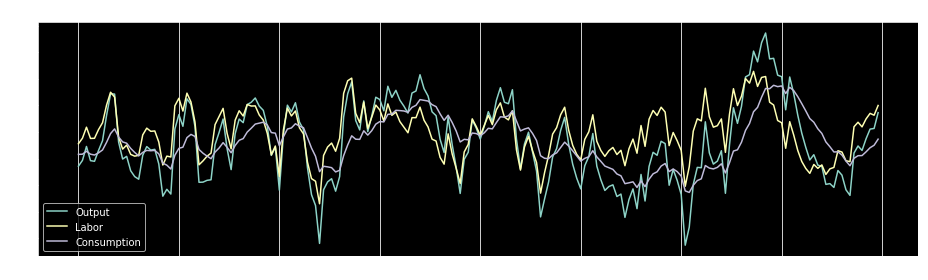

In [12]:
fig, ax = plt.subplots(figsize=(13,4))

ax.plot(sim_observed[:,0], label='Output')
ax.plot(sim_observed[:,1], label='Labor')
ax.plot(sim_observed[:,2], label='Consumption')

ax.set_title('Simulated observed series')
ax.xaxis.grid()
ax.legend(loc='lower left')

fig.tight_layout();


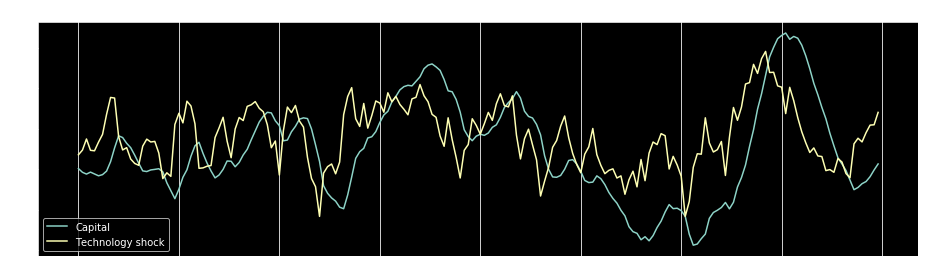

In [13]:
fig, ax = plt.subplots(figsize=(13,4))

ax.plot(sim_state[:,0], label='Capital')
ax.plot(sim_state[:,1], label='Technology shock')

ax.set_title('Simulated unobserved states')
ax.xaxis.grid()
ax.legend(loc='lower left')

fig.tight_layout();


In [14]:
start='1984-01'
end = '2015-01'
labor = DataReader('HOANBS', 'fred', start=start, end=end)        # hours
consumption = DataReader('PCECC96', 'fred', start=start, end=end) # billions of dollars
investment = DataReader('GPDI', 'fred', start=start, end=end)     # billions of dollars
population = DataReader('CNP16OV', 'fred', start=start, end=end)  # thousands of persons
recessions = DataReader('USRECQ', 'fred', start=start, end=end)

# Collect the raw values
raw = pd.concat((labor, consumption, investment, population.resample('QS').mean()), axis=1)
raw.columns = ['labor', 'consumption', 'investment', 'population']
raw['output'] = raw['consumption'] + raw['investment']

# Make the data consistent with the model
y = np.log(raw.output * 10**(9-3) / raw.population)
n = np.log(raw.labor * (1e3 * 40) / raw.population)
c = np.log(raw.consumption * 10**(9-3) / raw.population)

# Make the data stationary
y = y.diff()[1:]
n = n.diff()[1:]
c = c.diff()[1:]

# Construct the final dataset
econ_observed = pd.concat((y, n, c), axis=1)
econ_observed.columns = ['output','labor','consumption']


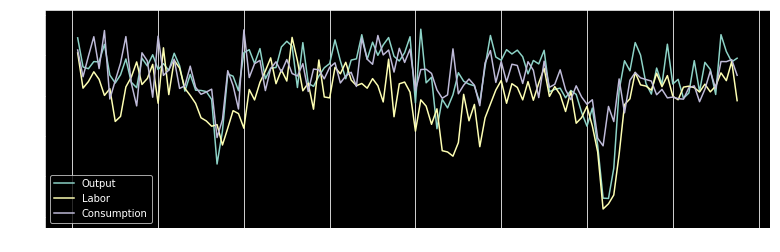

In [15]:
fig, ax = plt.subplots(figsize=(13,4))

dates = econ_observed.index._mpl_repr()

ax.plot(dates, econ_observed.output, label='Output')
ax.plot(dates, econ_observed.labor, label='Labor')
ax.plot(dates, econ_observed.consumption, label='Consumption')

rec = recessions.resample('QS').last().loc[econ_observed.index[0]:].iloc[:, 0].values
ylim = ax.get_ylim()
ax.fill_between(dates, ylim[0]+1e-5, ylim[1]-1e-5, rec, facecolor='k', alpha=0.1)

ax.xaxis.grid()
ax.legend(loc='lower left');


In [16]:
class EstimateRBC1(sm.tsa.statespace.MLEModel):
    def __init__(self, output=None, labor=None, consumption=None,
                 measurement_errors=True,
                 disutility_labor=3, depreciation_rate=0.025,
                 capital_share=0.36, **kwargs):

        # Determine provided observed variables
        self.output = output is not None
        self.labor = labor is not None
        self.consumption = consumption is not None
        self.observed_mask = (
            np.array([self.output, self.labor, self.consumption], dtype=bool)
        )

        observed_variables = np.r_[['output', 'labor', 'consumption']]
        self.observed_variables = observed_variables[self.observed_mask]

        self.measurement_errors = measurement_errors

        # Construct the full endogenous array
        endog = []
        if self.output:
            endog.append(np.array(output))
        if self.labor:
            endog.append(np.array(labor))
        if self.consumption:
            endog.append(np.array(consumption))
        endog = np.c_[endog].transpose()

        # Initialize the statespace model
        super(EstimateRBC1, self).__init__(endog, k_states=2, k_posdef=1, **kwargs)
        self.initialize_stationary()
        self.data.ynames = self.observed_variables

        # Check for stochastic singularity
        if self.k_endog > 1 and not measurement_errors:
            raise ValueError('Stochastic singularity encountered')

        # Save the calibrated parameters
        self.disutility_labor = disutility_labor
        self.depreciation_rate = depreciation_rate
        self.capital_share = capital_share

        # Create the structural model
        self.structural = ReducedRBC2()

        # Setup fixed elements of the statespace matrices
        self['selection', 1, 0] = 1

        idx = np.diag_indices(self.k_endog)
        self._idx_obs_cov = ('obs_cov', idx[0], idx[1])

    @property
    def start_params(self):
        start_params = [0.99, 0.5, 0.01]
        if self.measurement_errors:
            start_meas_error = np.r_[[0.1]*3]
            start_params += start_meas_error[self.observed_mask].tolist()

        return start_params

    @property
    def param_names(self):
        param_names = ['beta', 'rho', 'sigma.vareps']
        if self.measurement_errors:
            meas_error_names = np.r_[['sigma2.y', 'sigma2.n', 'sigma2.c']]
            param_names += meas_error_names[self.observed_mask].tolist()

        return param_names

    def transform_params(self, unconstrained):
        constrained = np.zeros(unconstrained.shape, unconstrained.dtype)

        # Discount rate is between 0 and 1
        constrained[0] = max(1 / (1 + np.exp(unconstrained[0])) - 1e-4, 1e-4)
        # Technology shock persistence is between -1 and 1
        constrained[1] = unconstrained[1] / (1 + np.abs(unconstrained[1]))
        # Technology shock std. dev. is positive
        constrained[2] = np.abs(unconstrained[2])
        # Measurement error variances must be positive
        if self.measurement_errors:
            constrained[3:3+self.k_endog] = unconstrained[3:3+self.k_endog]**2

        return constrained

    def untransform_params(self, constrained):
        unconstrained = np.zeros(constrained.shape, constrained.dtype)

        # Discount rate is between 0 and 1
        unconstrained[0] = np.log((1 - constrained[0] + 1e-4) / (constrained[0] + 1e-4))
        # Technology shock persistence is between -1 and 1
        unconstrained[1] = constrained[1] / (1 + constrained[1])
        # Technology shock std. dev. is positive
        unconstrained[2] = constrained[2]
        # Measurement error variances must be positive
        if self.measurement_errors:
            unconstrained[3:3+self.k_endog] = constrained[3:3+self.k_endog]**0.5

        return unconstrained

    def update(self, params, **kwargs):
        params = super(EstimateRBC1, self).update(params, **kwargs)

        # Get the parameters of the structural model
        # Note: we are calibrating three parameters
        structural_params = np.r_[
            params[0],
            self.disutility_labor,
            self.depreciation_rate,
            self.capital_share,
            params[1:3]
        ]

        # Solve the model
        design, transition = self.structural.solve(structural_params)

        # Update the statespace representation
        self['design'] = design[self.observed_mask, :]
        if self.measurement_errors:
            self[self._idx_obs_cov] = params[3:3+self.k_endog]
        self['transition'] = transition
        self['state_cov', 0, 0] = self.structural.technology_shock_std**2


In [17]:
sim_mod = EstimateRBC1(
    output=sim_observed[:,0],
    labor=sim_observed[:,1],
    consumption=sim_observed[:,2],
    measurement_errors=True
)

# sim_res = sim_mod.fit(maxiter=1000, information_matrix_type='oim')
sim_res = sim_mod.fit(maxiter=1000)

print(sim_res.summary())


                                  Statespace Model Results                                  
Dep. Variable:     ['output' 'labor' 'consumption']   No. Observations:                  200
Model:                                 EstimateRBC1   Log Likelihood                2733.906
Date:                              Wed, 06 Mar 2019   AIC                          -5455.811
Time:                                      02:59:35   BIC                          -5436.021
Sample:                                           0   HQIC                         -5447.803
                                              - 200                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
beta             0.9501   3.38e-05   2.81e+04      0.000       0.950       0.950
rho          

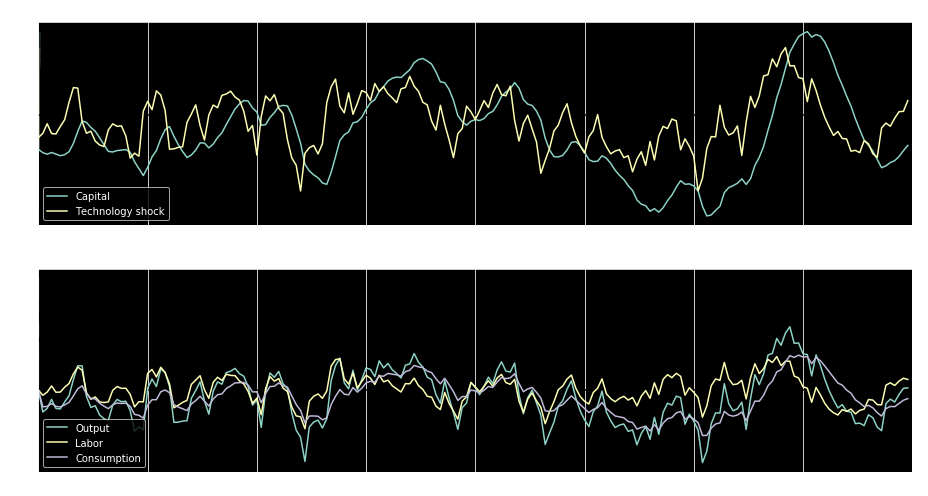

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(13,7))

# Filtered states confidence intervals
states_cov = np.diagonal(sim_res.filtered_state_cov).T
states_upper = sim_res.filtered_state + 1.96 * states_cov**0.5
states_lower = sim_res.filtered_state - 1.96 * states_cov**0.5

ax = axes[0]
lines, = ax.plot(sim_res.filtered_state[0], label='Capital')
ax.fill_between(states_lower[0], states_upper[0], color=lines.get_color(), alpha=0.2)

lines, = ax.plot(sim_res.filtered_state[1], label='Technology shock')
ax.fill_between(states_lower[1], states_upper[1], color=lines.get_color(), alpha=0.2)

ax.set_xlim((0, 200))
ax.hlines(0, 0, 200)

ax.set_title('Filtered states (simulated data)')
ax.legend(loc='lower left')
ax.xaxis.grid()

ax = axes[1]

# One-step-ahead forecasts confidence intervals
forecasts_cov = np.diagonal(sim_res.forecasts_error_cov).T
forecasts_upper = sim_res.forecasts + 1.96 * forecasts_cov**0.5
forecasts_lower = sim_res.forecasts - 1.96 * forecasts_cov**0.5

for i in range(sim_mod.k_endog):
    lines, = ax.plot(sim_res.forecasts[i], label=sim_mod.endog_names[i].title())
    ax.fill_between(forecasts_lower[i], forecasts_upper[i], color=lines.get_color(), alpha=0.1)

ax.set_xlim((0, 200))
ax.hlines(0, 0, 200)

ax.set_title('One-step-ahead forecasts (simulated data)')
ax.legend(loc='lower left')
ax.xaxis.grid()

fig.tight_layout();


In [19]:
econ_mod = EstimateRBC1(
    output=econ_observed['output'],
    labor=econ_observed['labor'],
    consumption=econ_observed['consumption'],
    measurement_errors=True,
    dates=econ_observed.index
)

econ_res = econ_mod.fit(maxiter=1000, information_matrix_type='oim')

print(econ_res.summary())


C:\Users\Satoshi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
C:\Users\Satoshi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


                                  Statespace Model Results                                  
Dep. Variable:     ['output' 'labor' 'consumption']   No. Observations:                  124
Model:                                 EstimateRBC1   Log Likelihood                1446.774
Date:                              Wed, 06 Mar 2019   AIC                          -2881.547
Time:                                      02:59:37   BIC                          -2864.626
Sample:                                  04-01-1984   HQIC                         -2874.673
                                       - 01-01-2015                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
beta             0.9850      0.010     96.660      0.000       0.965       1.005
rho          

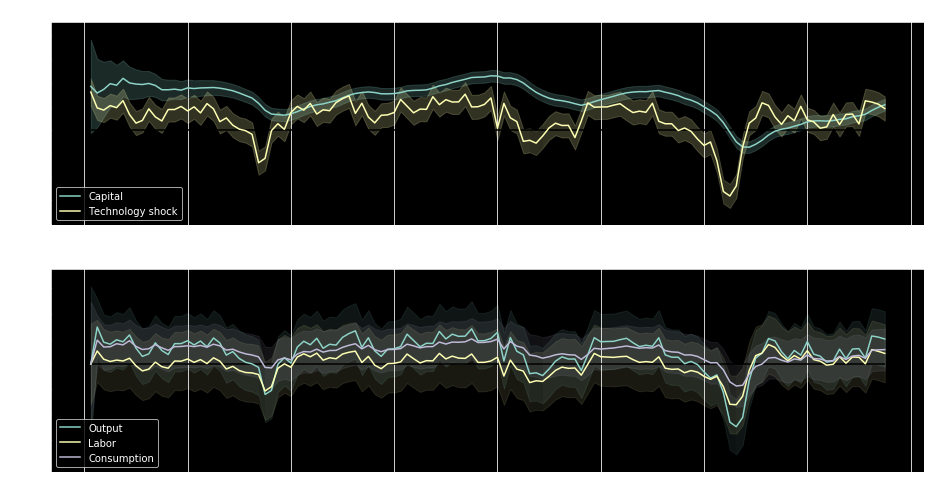

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(13,7))

# Filtered states confidence intervals
states_cov = np.diagonal(econ_res.filtered_state_cov).T
states_upper = econ_res.filtered_state + 1.96 * states_cov**0.5
states_lower = econ_res.filtered_state - 1.96 * states_cov**0.5

ax = axes[0]
lines, = ax.plot(dates, econ_res.filtered_state[0], label='Capital')
ax.fill_between(dates, states_lower[0], states_upper[0], color=lines.get_color(), alpha=0.2)

lines, = ax.plot(dates, econ_res.filtered_state[1], label='Technology shock')
ax.fill_between(dates, states_lower[1], states_upper[1], color=lines.get_color(), alpha=0.2)

ylim = ax.get_ylim()
ax.fill_between(dates, ylim[0]+1e-4, ylim[1]-1e-4, rec, facecolor='k', alpha=0.1)

ax.hlines(0, dates[0], dates[-1])

ax.set_title('Filter')
ax.legend(loc='lower left')
ax.xaxis.grid()

ax = axes[1]

# One-step-ahead forecasts confidence intervals
forecasts_cov = np.diagonal(econ_res.forecasts_error_cov).T
forecasts_upper = econ_res.forecasts + 1.96 * forecasts_cov**0.5
forecasts_lower = econ_res.forecasts - 1.96 * forecasts_cov**0.5

for i in range(econ_mod.k_endog):
    lines, = ax.plot(dates, econ_res.forecasts[i], label=econ_mod.endog_names[i].title())
    ax.fill_between(dates, forecasts_lower[i], forecasts_upper[i], color=lines.get_color(), alpha=0.1)

ylim = ax.get_ylim()
ax.fill_between(dates, ylim[0]+1e-4, ylim[1]-1e-4, rec, facecolor='k', alpha=0.1)

ax.hlines(0, dates[0], dates[-1])

ax.set_title('One-step-ahead forecasts')
ax.legend(loc='lower left')
ax.xaxis.grid()

fig.tight_layout();
